In [9]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [10]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    if velocities.size == 0:
        return 0.0
    # Avoid division by zero
    else:
        return np.std(velocities)
    

# Define the log-normal function
def log_normal(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [11]:
def get_mass_functions(simulation, snapshot=127, subdir='/output/', age_young = 1., age_intermediate=6., age_old=10., inner_radius=0., outer_radius=None,\
                       low_mass_cut=None, high_mass_cut=None, apply_df=False, decomposition=None, plot_agedistribution=False, plot_dynamicfriction=False, plot_decomposition=False):
    print('Loading simulation: '+simulation)
    sf = load_subfind(snapshot, dir=simulation+subdir, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=simulation+subdir, subfind=sf, hdf5=True, loadonlyhalo=0)
    s.calc_sf_indizes( sf )
    galrad = 0.25 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )
    if outer_radius is None:
        outer_radius = 1e3*galrad

    print('Stellar mass of the galaxy: {:2.2e} Msun'.format(1e10*sf.data['smty'][0, 4]))

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    Gcosmo = 43.
    starparts = (s.data['age']>0.) * (s.r()[s.data['type']==4] < galrad)
    
    kinetic_energy = np.sum(s.data['vel']**2, axis=1)

    orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
    orbital_energy /= 1e5
    
    Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]

    parts_radius = s.r()
    isort_parts = np.argsort(parts_radius)
    revert_sort = np.argsort(isort_parts)
    cummass = np.cumsum(s.data['mass'][isort_parts])
    Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)

    # Energy of circular orbits at increasing radii
    Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
    Ecirc /= 1e5
    e_max = np.nanmax(Ecirc[~np.isinf(Ecirc)])
    orbital_energy -= e_max
    Ecirc -= e_max
    
    mask_clusters_initial = ((s.data['incl'][starparts] > 0 ) * (1e3*parts_radius[s.data['type']==4][starparts] > inner_radius) *
                            (1e3*parts_radius[s.data['type']==4][starparts] <= outer_radius)) # * (np.abs(1e3*s.data['pos'][starparts,0])>0.2))
    
    jz = Lz[s.data['type']==4][starparts]
    ii = np.argsort(orbital_energy[s.data['type']==4][starparts])
    eps = jz[ii]
    npm = 50
    eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
    ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
    ilist = ilist[ii] # ilist=5,4,3,2,1
    resort = np.argsort(ilist) # resort=5,4,3,2,1
    eps = eps[resort] # eps2=5,4,3,2,1

    if decomposition is None:
        mask_decomposition = np.ones_like(eps[mask_clusters_initial], dtype=bool)
    else:
        # Build feature array: [ε, Energy]
        X = np.vstack((eps,orbital_energy[s.data['type']==4][starparts],
                       np.log10(np.abs(s.data['pos'][:,0][s.data['type']==4][starparts])))).T

        # Fit GMM
        gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[s.data['type']==4][starparts]), -1.5],
                                                          [0.9,np.median(orbital_energy[s.data['type']==4][starparts]), -2.5]],
                                                          covariance_type='full', random_state=42)
        gmm.fit(X)

        # Predict cluster memberships
        decomp_labels = gmm.predict(X)
        median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
        sph_label = np.argmin(median_eps)
        disc_label = np.argmax(median_eps)

        #Force assign disc_label to clusters with high circularity
        mask = (decomp_labels == sph_label) & (eps > 0.7)
        decomp_labels[mask] = disc_label
        
        if decomposition == 'Spheroid':
            print('GMM Label for Spheroid:', sph_label)
            mask_decomposition = decomp_labels[mask_clusters_initial] == sph_label
        elif decomposition == 'Disc':
            print('GMM Label for Disc:', disc_label)
            mask_decomposition = decomp_labels[mask_clusters_initial] == disc_label

        if plot_decomposition:
            label_color = plt.cm.viridis(np.linspace(0, 1, 2))
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].scatter(eps, orbital_energy[s.data['type']==4][starparts],
                        c=decomp_labels, s=1, cmap='viridis', alpha=0.5, edgecolors='face')
            ax[0].set(xlabel='Circularity ε', ylabel='Energy', xlim=(-2,2))

            ax[1].hist(eps, histtype='step', bins=20, range=[-1.5,1.5], label='Stars with SCs')
            for i in range(gmm.n_components):
                ax[1].hist(eps[(decomp_labels==i)], histtype='step', edgecolor=label_color[i], bins=20, range=[-1.5,1.5], label=f'Component {i}')
            ax[1].get_yaxis().set_ticks([])
            ax[1].legend(loc='upper left')
            ax[1].set_xlabel('Circularity ε')
            plt.show()
    
    cluster_masses = s.data['mclt'][starparts][mask_clusters_initial][mask_decomposition].flatten()
    init_cluster_masses = s.data['imcl'][starparts][mask_clusters_initial][mask_decomposition].flatten()
    
    not_empty_clusters = (init_cluster_masses>0.)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    print('Maximum initial number of clusters per star {:d}'.format(s.data['incl'].max()))
    print('Maximum initial mass {:2.2e} Msun'.format(1e10*init_cluster_masses.max()))
    print('Maximum present-day mass {:2.2e} Msun'.format(1e10*cluster_masses.max()))

    clusters_formtime = np.repeat(s.data['age'][starparts][mask_clusters_initial][mask_decomposition], s.data['incl'][starparts][mask_clusters_initial][mask_decomposition])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

    mask_problematic = s.data['imfc'][starparts][mask_clusters_initial][mask_decomposition]>1.
    print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
    print('That`s {:.3f} per cent of stars with clusters'.format(mask_problematic.sum()/len(s.data['imfc'][starparts][mask_clusters_initial][mask_decomposition]) * 100))

    if low_mass_cut is None:
        low_mass_cut = 1e2
    if high_mass_cut is None:
        high_mass_cut = 1e8
    
    not_empty_clusters = (cluster_masses>0.)
    init_mass_cut = (1e10*init_cluster_masses[not_empty_clusters]>low_mass_cut) * (1e10*init_cluster_masses[not_empty_clusters]<high_mass_cut)
    
    if plot_agedistribution:
        plt.hist(clusters_age[not_empty_clusters][init_mass_cut], bins=20, histtype='step', density=True)
        plt.xlabel('Cluster`s age [Gyr]')
        plt.ylabel('Age Distribution')
        plt.title(simulation)
        plt.show()
    
    if apply_df:
        mask = mask_equal_to_previous(parts_radius[isort_parts][~np.isinf(Ecirc)])

        r_test = np.logspace(-5, np.log10(parts_radius.max()), 500)
        Ecirc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask])
        Vc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask])
        Mr_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], cummass[~np.isinf(Ecirc)][mask])

        Jtot = np.sqrt((np.cross( s.data['pos'], (s.data['vel'] ))**2).sum(axis=1))
        idx = np.argmin(np.abs(orbital_energy[s.data['type']==4][starparts][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
        rc = r_test[idx]
        vc = Vc_f(rc)
        Lzmax = rc*vc

        rc_clus = np.repeat(rc[mask_clusters_initial][mask_decomposition], s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition])[init_mass_cut]
        M_rc_clus = Mr_f(rc[mask_clusters_initial][mask_decomposition])
        M_rc_clus = np.repeat(M_rc_clus, s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition])[init_mass_cut]
        vc_rc_clus = np.repeat(vc[mask_clusters_initial][mask_decomposition], s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition])[init_mass_cut]
        sigma_rc_clus = np.array([velocity_dispersion(r, s.r(), starparts, s.data['age'], s.data['vel'], s.data['type']) for r in 
                                rc[mask_clusters_initial][mask_decomposition][s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition]>0]])
        sigma_rc_clus = np.repeat(sigma_rc_clus,\
                                  s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition][s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition]>0])[init_mass_cut]

        feps = np.repeat((Jtot[s.data['type']==4][starparts][mask_clusters_initial][mask_decomposition]/Lzmax[mask_clusters_initial][mask_decomposition])**0.78,\
                          s.data['nclt'][starparts][mask_clusters_initial][mask_decomposition])[init_mass_cut]
        coulumblog = np.log(1. + M_rc_clus/cluster_masses[not_empty_clusters][init_mass_cut])
        
        tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*cluster_masses[not_empty_clusters][init_mass_cut]*coulumblog)
        tdf *= s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s / (1e9*365.25*24*3600)

        mask_disrupted = (tdf < clusters_age[not_empty_clusters][init_mass_cut])
        print('Clusters disrupted by dynamical friction {:4d}'.format(mask_disrupted.sum()))
        if(plot_dynamicfriction):
            plt.hist(tdf, bins=np.logspace(-1, 3, 20), histtype='step')
            plt.xscale('log')
            plt.xlabel('Dynamical Friction Timescale [Gyr]')
            plt.ylabel('Number of clusters')
            plt.title(simulation)
            plt.show()
    else:
        mask_disrupted = np.zeros_like(cluster_masses[not_empty_clusters][init_mass_cut], dtype=bool)
        if(plot_dynamicfriction):
            print('Bad usage, no DF applied')

    young_mask = (clusters_age[not_empty_clusters][init_mass_cut][~mask_disrupted]<age_young)
    intemediate_mask = (clusters_age[not_empty_clusters][init_mass_cut][~mask_disrupted]>age_intermediate)
    old_mask = (clusters_age[not_empty_clusters][init_mass_cut][~mask_disrupted]>age_old)

    nbins = 25
    min_gcmf = 1e2 # in solar masses
    min_icmf = 5e3 # in solar masses
    max_gcmf = 1e8 # in solar masses
    marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
    marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_gcmf), nbins + 1)
    width_gcmf = np.diff(marray_gcmf)
    width_icmf = np.diff(marray_icmf)

    init_mass_mask = (1e10*init_cluster_masses>low_mass_cut) * (1e10*init_cluster_masses<high_mass_cut)
    N,_ = np.histogram(np.log10(1e10*init_cluster_masses[init_mass_mask]), bins=marray_icmf)
    initial_population = N/width_icmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][~mask_disrupted]), bins=marray_gcmf)
    full_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][~mask_disrupted][young_mask]), bins=marray_gcmf)
    young_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][~mask_disrupted][intemediate_mask]), bins=marray_gcmf)
    intermediate_population = N/width_gcmf
    N,_ = np.histogram(np.log10(1e10*cluster_masses[not_empty_clusters][init_mass_cut][~mask_disrupted][old_mask]), bins=marray_gcmf)
    old_population = N/width_gcmf

    return [initial_population, full_population, young_population, intermediate_population, old_population]

In [12]:
nbins = 25
min_gcmf = 1e2 # in solar masses
min_icmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)
marray_plot = 0.5 * (marray_gcmf[:-1] + marray_gcmf[1:])
imarray_plot = 0.5 * (marray_icmf[:-1] + marray_icmf[1:])

In [13]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
m31_rgc = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=12, delimiter=',')
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(m31_masses[m31_rgc <= 3.], bins=marray_gcmf)
m31_inner_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 3.) * (m31_rgc <= 9.)], bins=marray_gcmf)
m31_intermediate_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 9.)], bins=marray_gcmf)
m31_outer_mass_function = N/width

mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
mw_rgc = mw_catalogue[:,2]
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width
N,_ = np.histogram(mw_masses[mw_rgc <= 3.], bins=marray_gcmf)
mw_inner_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 3.) * (mw_rgc <= 9.)], bins=marray_gcmf)
mw_intermediate_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 9.)], bins=marray_gcmf)
mw_outer_mass_function = N/width

emosaics_6gyr = np.genfromtxt('catalogues_compare/emosaics_gcmf.csv', delimiter=',', skip_header=2)
emosaics_6gyr_masses = emosaics_6gyr[:,::2]
emosaics_6gyr_counts = emosaics_6gyr[:,1::2]
emosaics_gcmf_6gyr = np.zeros((marray_plot.size,10))
for i in range(10):
    for j in range(marray_plot.size):
        min_idx = np.nanargmin(np.abs(emosaics_6gyr_masses[:,i] - marray_plot[j]))
        emosaics_gcmf_6gyr[j,i] = emosaics_6gyr_counts[min_idx,i]

emosaics_10gyr = np.genfromtxt('catalogues_compare/emosaics_gcmf_10gyr.csv', delimiter=',', skip_header=2)
emosaics_gcmf_10gyr = emosaics_10gyr[:,:2]
emosaics_sigma_10gyr = emosaics_10gyr[:-2,2:]

In [14]:
dir = './'
# simulation_list = [directory for directory in os.listdir(dir) if 'Au6_lvl4_04d8' in directory]
# print(simulation_list)
# simulation_list = [simulation_list[11], simulation_list[1]] 
# print(simulation_list)
# simulation_list = ['Au6_lvl4_cfea_scbase', 'Au6_lvl4_cfea_emosaics']
# simulation_list = ['Au6_lvl4_cfea_compressive', 'Au6_lvl4_cfea_fiducial']
simulation_list = ['Au6_lvl4_cfea_fiducial', 'Au6_lvl4_cfea_sh50myr10']

Loading simulation: Au6_lvl4_cfea_sh50myr10
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 2.42e+07 Msun
Problematic stars with clusters 6805
That`s 9.935 per cent of stars with clusters


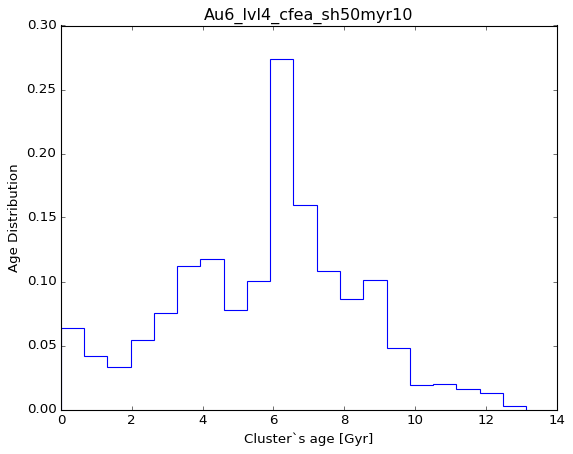

Loading simulation: Au6_lvl4_cfea_sh50myr10
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0


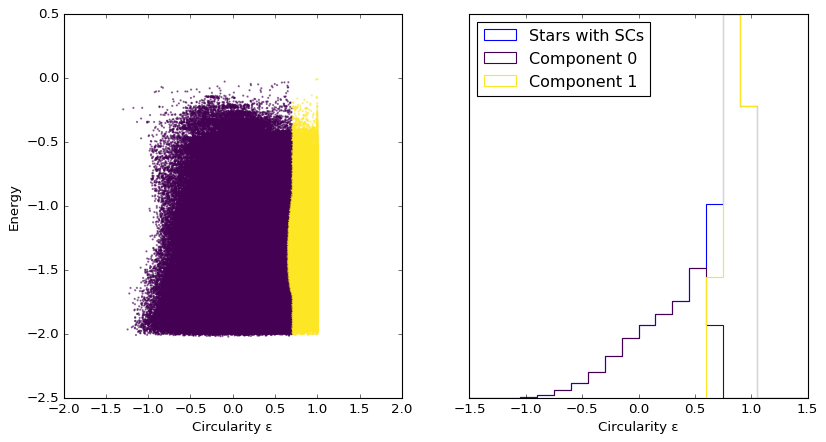

Maximum initial number of clusters per star 6
Maximum initial mass 3.84e+07 Msun
Maximum present-day mass 1.91e+07 Msun
Problematic stars with clusters 4065
That`s 10.251 per cent of stars with clusters


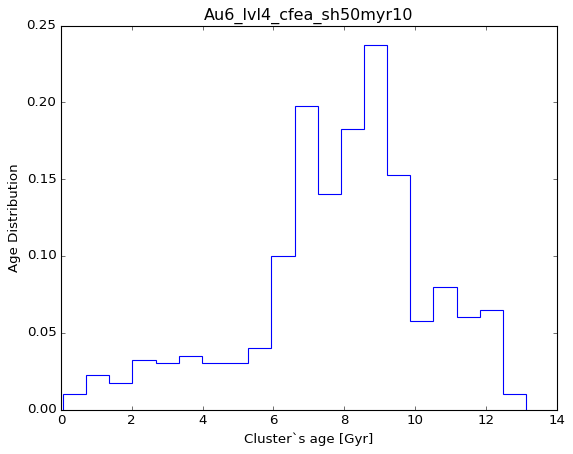

Loading simulation: Au6_lvl4_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 2.42e+07 Msun
Problematic stars with clusters 6805
That`s 9.935 per cent of stars with clusters


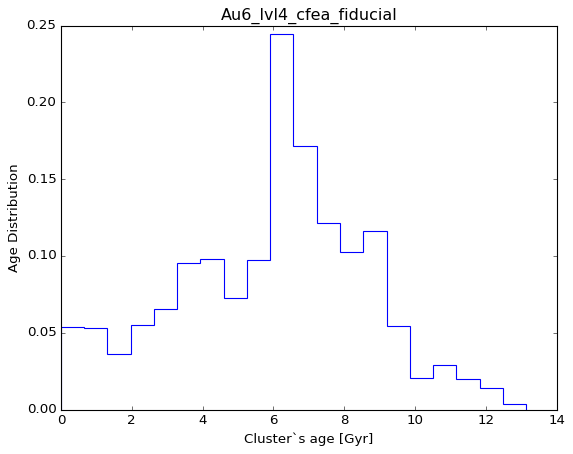

In [17]:
base_init, base_full, base_young, base_intermediate, base_old = get_mass_functions(simulation_list[1], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., apply_df=False,\
                                                                                   decomposition=None, plot_agedistribution=True, plot_decomposition=True, low_mass_cut=None)
gcsel_init, gcsel_full, gcsel_young, gcsel_intermediate, gcsel_old = get_mass_functions(simulation_list[1], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., apply_df=False,\
                                                                                   decomposition='Spheroid', plot_agedistribution=True, plot_decomposition=True, low_mass_cut=1e5)
emoslike_init, emoslike_full, emoslike_young, emoslike_intermediate, emoslike_old = get_mass_functions(simulation_list[0], snapshot=127, subdir='/output/',\
                                                                                   age_intermediate=6., age_old=10., apply_df=False,\
                                                                                   decomposition=None, plot_agedistribution=True, plot_decomposition=True, low_mass_cut=None)

10.22413153517153 10.728353782021228


Text(7, 400000.0, 'Au6, Baseline')

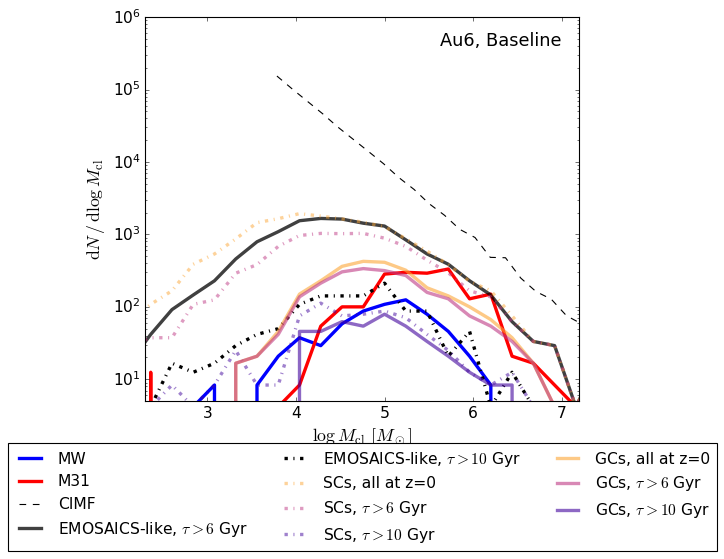

In [19]:
emosaics_icmf_max = np.array([162981.01556600325,196088.818693284,309432.5795144362,186812.29042889702,85305.5264213018,
                              220152.18729419354,104630.52274409348,55539.46369413565,54431.34383763517,74556.57421133538])
emosaics_mstar_gals = 10**np.array([10.28, 10.38, 10.56, 10.42, 10.11, 10.12, 10.31, 10.16, 10.12, 10.16])
print(np.log10(np.median(emosaics_mstar_gals)), np.log10(5.35e10))
scale_fac = np.max(base_init) / np.median(emosaics_icmf_max)

fig, ax = plt.subplots(1,1, figsize=(7,6))
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))

ax.plot(marray_plot, mw_mass_function,linewidth=3, c='b', label='MW')
ax.plot(marray_plot, m31_mass_function,linewidth=3, c='r', label='M31')
# ax.plot(marray_plot, np.median(emosaics_gcmf_6gyr, axis=1)/np.median(emosaics_mstar_gals), c='k', linewidth=3, linestyle='--', label=r'EMOSAICS, $\tau > 6 \; \rm{Gyr}$')
# ax.fill_between(marray_plot, np.quantile(emosaics_gcmf_6gyr, 0.16, axis=1)/np.median(emosaics_mstar_gals), np.quantile(emosaics_gcmf_6gyr, 0.84, axis=1)/np.median(emosaics_mstar_gals), color='k', alpha=0.2)
# ax.plot(np.log10(emosaics_gcmf_10gyr[:,0]), emosaics_gcmf_10gyr[:,1]/np.median(emosaics_mstar_gals), c='k', linewidth=3, linestyle='--', label=r'EMOSAICS, $\tau > 10 \; \rm{Gyr}$')
# ax.fill_between(np.log10(np.mean(emosaics_sigma_10gyr[:,0::2], axis=1)), emosaics_sigma_10gyr[:,1]/np.median(emosaics_mstar_gals), emosaics_sigma_10gyr[:,3]/np.median(emosaics_mstar_gals), color='k', alpha=0.2)
ax.plot(imarray_plot, base_init,c='k', linestyle='dashed', linewidth = 1, label='CIMF')
# # ax.plot(imarray_plot, emoslike_init / scale_fac,c='k', linestyle='-.', linewidth = 1, alpha=0.75)
ax.plot(marray_plot, emoslike_intermediate,c='k', linestyle='solid', linewidth = 3, alpha=0.75, label=r'EMOSAICS-like, $\tau > 6$ Gyr')
ax.plot(marray_plot, emoslike_old,c='k', linestyle='-.', linewidth = 3, label=r'EMOSAICS-like, $\tau > 10$ Gyr')
ax.plot(marray_plot, base_full,c=colors[0], alpha=0.5, linestyle='dashdot', linewidth = 3, label='SCs, all at z=0')
ax.plot(marray_plot, base_intermediate,c=colors[1], alpha=0.5, linestyle='dashdot', linewidth = 3, label=r'SCs, $\tau > 6$ Gyr')
ax.plot(marray_plot, base_old,c=colors[2], alpha=0.5, linestyle='dashdot', linewidth = 3, label=r'SCs, $\tau > 10$ Gyr')
ax.plot(marray_plot, gcsel_full,c=colors[0], alpha=0.6, linestyle='solid', linewidth = 3, label='GCs, all at z=0')
ax.plot(marray_plot, gcsel_intermediate,c=colors[1], alpha=0.6, linestyle='solid', linewidth = 3, label=r'GCs, $\tau > 6$ Gyr')
ax.plot(marray_plot, gcsel_old,c=colors[2], alpha=0.6, linestyle='solid', linewidth = 3, label=r'GCs, $\tau > 10$ Gyr')
# ax.text(5, 5e4, 'CIMF', fontsize=16, rotation=-44, color='k', ha='center', va='center')
ax.set_xlim(2.3,7.2)
ax.set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
ax.set_yscale('log')
ax.set_ylim(5e0, 1e6)
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(loc='center', fontsize=14, bbox_to_anchor=(0.5, -0.25), ncol=3)
# ax.set_title(r'Baseline Model', fontsize=16)
ax.text(7, 4e5, 'Au6, Baseline', ha='right', fontsize=16)
# plt.savefig('plots/baseline_mfs_paper.pdf', bbox_inches='tight')

In [7]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []
# labels = ['GCs, Compressive-Only Model', 'GCs, Fiducial Model']
labels = ['GCs, Fiducial Model', 'GCs, Enhanced CCE (x10 in 50Myr)']

for i, sim in enumerate(simulation_list):
    labels.append(sim)
    # if i == 0:
    init, full, young, intermediate, old = get_mass_functions(sim, snapshot=127, apply_df=False, subdir='/output/', age_intermediate=6., age_old=10., decomposition='Spheroid', low_mass_cut=1e5)
    # else:
    #     init, full, young, intermediate, old = get_mass_functions(sim, snapshot=127, apply_df=False, subdir='/output/', age_intermediate=6., age_old=8., exclude_disk=True)
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

Loading simulation: Au6_lvl4_cfea_fiducial
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 3.84e+07 Msun
Maximum present-day mass 1.91e+07 Msun
Problematic stars with clusters 4065
That`s 10.251 per cent of stars with clusters
Loading simulation: Au6_lvl4_cfea_sh50myr10
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Stellar mass of the galaxy: 5.35e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 3.84e+07 Msun
Maximum present-day mass 1.91e+07 Msun
Problematic stars with clusters 4065
That`s 10.251 per cent of stars with clusters


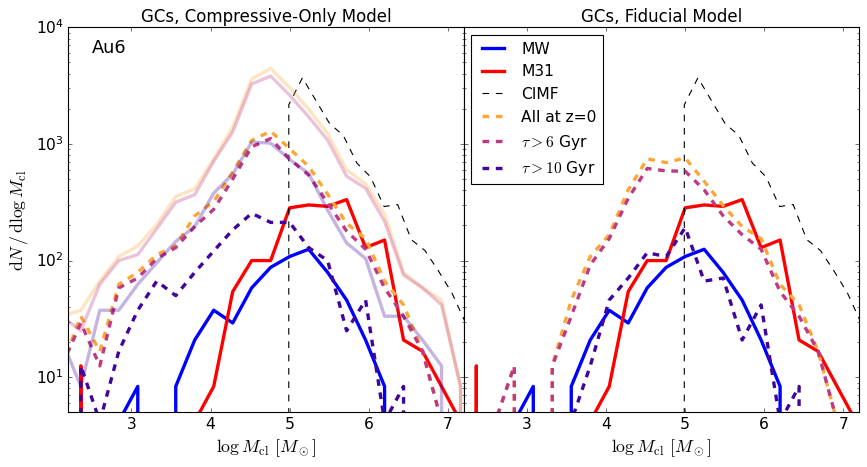

In [13]:
nsubs = 2
fig, ax = plt.subplots(1, nsubs, sharey=True, figsize=(nsubs*5 + 1,6))
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))

poptmw, _ = curve_fit(log_normal, marray_plot, mw_mass_function, p0=[1e3, 5, 0.5])
A, mu, sigma = poptmw
peakmw = mu  # The peak of the log-normal function

for i in range(len(ax)):
  ax[i].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
  # ax[i].arrow(peakmw, 1e1, 0, 10, color='b', linewidth=3, head_width=0.1, head_length=3, length_includes_head=True)
  ax[i].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
  ax[i].set_xlim(2.2,7.2)
  ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(labels[i], fontsize=15)
  # ax[i].grid(True, which='both', linewidth=0.2)

for i,mf in enumerate(initial_population):
  # if((i+1)%2 == 0):
  #   ax[i].plot(imarray_plot, initial_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(imarray_plot, mf, c='k', linestyle='--', linewidth=1, label='CIMF')

for i,mf in enumerate(full_population):
  # if((i+1)%2 == 0):
  #   ax[i].plot(marray_plot, full_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle='--', label='All at z=0')

for i,mf in enumerate(intermediate_population):
  # if((i+1)%2 == 0):
  #   ax[i].plot(marray_plot, intermediate_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle='--', label=r'$\tau > 6$ Gyr')
  # popt, _ = curve_fit(log_normal, marray_plot, mf, p0=[1e3, 5, 0.5])
  # A, mu, sigma = popt
  # ax[i].arrow(mu, 1e1, 0, 10, color=colors[1], linewidth=3, head_width=0.1, head_length=3, length_includes_head=True)  

for i,mf in enumerate(old_population):
  ax[i].plot(marray_plot, mf, c=colors[2], linewidth=3, linestyle='--', label=r'$\tau > 10$ Gyr')
  # if((i+1)%2 == 0):
  #   ax[i].plot(marray_plot, old_population[i-1], c='grey', linewidth=0.5)

ax[0].plot(marray_plot, gcsel_full,c=colors[0], linestyle='solid', alpha=0.3, linewidth = 3, label='GCs, all at z=0')
ax[0].plot(marray_plot, gcsel_intermediate,c=colors[1], linestyle='solid', alpha=0.3, linewidth = 3, label=r'GCs, $\tau > 6$ Gyr')
ax[0].plot(marray_plot, gcsel_old,c=colors[2], linestyle='solid', alpha=0.3, linewidth = 3, label=r'GCs, $\tau > 10$ Gyr')

ax[0].text(2.5, 6e3, 'Au6', fontsize=16, color='k')
ax[0].set(ylim=(5e0,1e4), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
ax[1].legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('plots/model_variations_gcmf_paper.pdf')

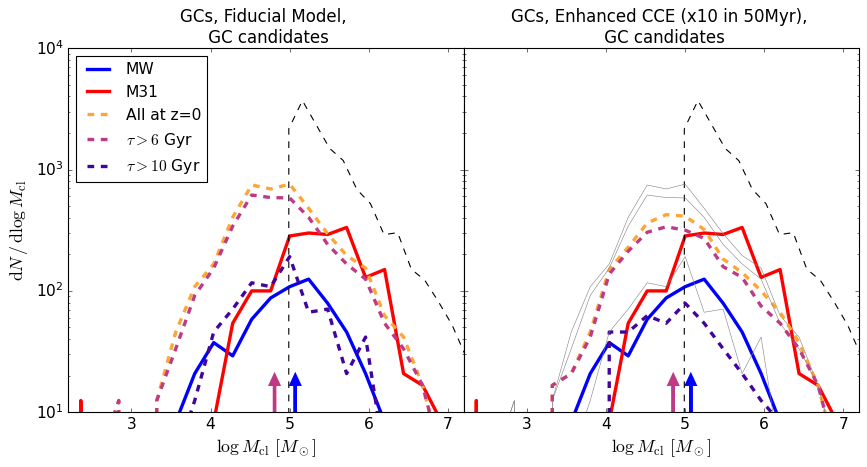

In [8]:
nsubs = 2
fig, ax = plt.subplots(1, nsubs, sharey=True, figsize=(nsubs*5 + 1,6))
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))

poptmw, _ = curve_fit(log_normal, marray_plot, mw_mass_function, p0=[1e3, 5, 0.5])
A, mu, sigma = poptmw
peakmw = mu  # The peak of the log-normal function

for i in range(len(ax)):
  ax[i].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
  ax[i].arrow(peakmw, 1e1, 0, 10, color='b', linewidth=3, head_width=0.1, head_length=3, length_includes_head=True)
  ax[i].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
  ax[i].set_xlim(2.2,7.2)
  ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(labels[i]+', \n GC candidates', fontsize=15)
  # ax[i].grid(True, which='both', linewidth=0.2)

for i,mf in enumerate(initial_population):
  # if((i+1)%2 == 0):
  #   ax[i].plot(imarray_plot, initial_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(imarray_plot, mf, c='k', linestyle='--', linewidth=1)

for i,mf in enumerate(full_population):
  if((i+1)%2 == 0):
    ax[i].plot(marray_plot, full_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle='--', label='All at z=0')

for i,mf in enumerate(intermediate_population):
  if((i+1)%2 == 0):
    ax[i].plot(marray_plot, intermediate_population[i-1], c='grey', linewidth=0.5)
  ax[i].plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle='--', label=r'$\tau > 6$ Gyr')
  popt, _ = curve_fit(log_normal, marray_plot, mf, p0=[1e3, 5, 0.5])
  A, mu, sigma = popt
  ax[i].arrow(mu, 1e1, 0, 10, color=colors[1], linewidth=3, head_width=0.1, head_length=3, length_includes_head=True)  
  
for i,mf in enumerate(old_population):
  ax[i].plot(marray_plot, mf, c=colors[2], linewidth=3, linestyle='--', label=r'$\tau > 10$ Gyr')
  if((i+1)%2 == 0):
    ax[i].plot(marray_plot, old_population[i-1], c='grey', linewidth=0.5)

# ax[1].text(6.5, 6e3, 'Au18', fontsize=16, color='k')
ax[0].set(ylim=(1e1,1e4), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
ax[0].legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('plots/disk_fimf_tview_gcmf_compare.pdf')

Loading simulation: Au6_lvl4_04d8_emosaicslike
galrad= 0.021384215
Found 1383217 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 8.78e+07 Msun
Maximum present-day mass 4.82e+07 Msun
Problematic stars with clusters 20953
That`s 8.650 per cent of stars with clusters
Loading simulation: Au6_lvl4_04d8_emosaicslike
galrad= 0.021384215
Found 1383217 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Maximum initial number of clusters per star 6
Maximum initial mass 8.78e+07 Msun
Maximum present-day mass 4.82e+07 Msun
Problematic stars with clusters 20953
That`s 8.650 per cent of stars with clusters
Loading simulation: Au6_lvl4_04d8_emosaicslike
galrad= 0.021384215
Found 1383217 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 6
Maximum initial mass 8.71e+07 Msun
Maxi

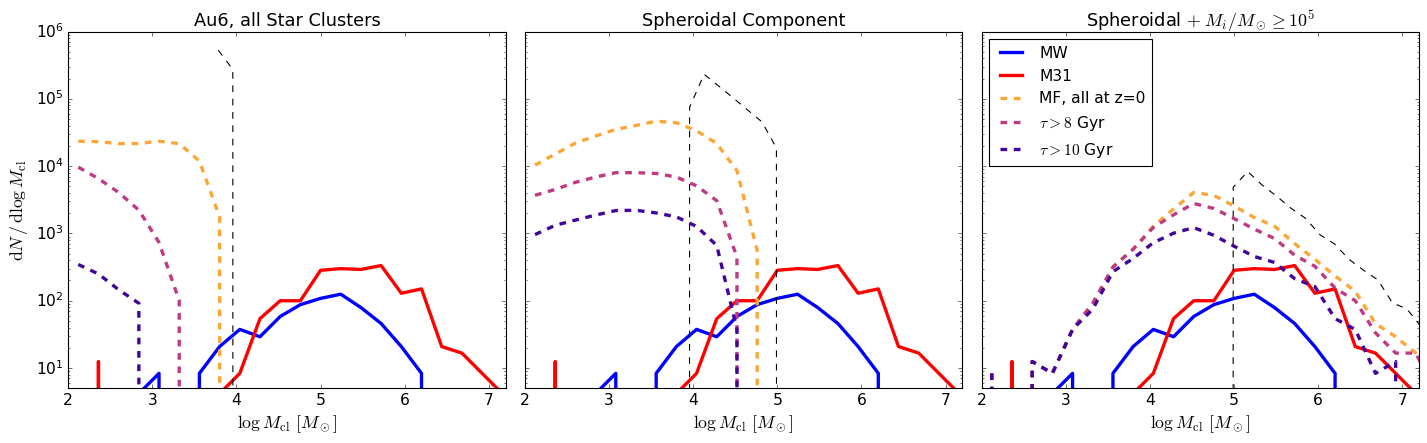

In [ ]:
labels=['Au6']
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
for ii, sim in enumerate(simulation_list[1:]):
    init_full_mass, all_full_mass, young_full_mass, intermediate_full_mass, old_full_mass = get_mass_functions(sim, \
                                                                                                        snapshot=127, subdir='/output/', age_intermediate=6.,\
                                                                                                        age_old=10., low_mass_cut=None, high_mass_cut=1e4, apply_df=False,\
                                                                                                        decomposition=None, plot_agedistribution=False, plot_decomposition=False)
    init_low_mass, all_low_mass, young_low_mass, intermediate_low_mass, old_low_mass = get_mass_functions(sim, \
                                                                                                        snapshot=127, subdir='/output/', age_intermediate=8.,\
                                                                                                        age_old=10., low_mass_cut=1e4, high_mass_cut=1e5, apply_df=False,\
                                                                                                        decomposition=None, plot_agedistribution=False, plot_decomposition=False)
    # init_intermediate_mass, all_intermediate_mass, young_intermediate_mass, intermediate_intermediate_mass, old_intermediate_mass = get_mass_functions(sim, \
    #                                                                                                     snapshot=127, subdir='/output/', age_intermediate=8.,\
    #                                                                                                     age_old=10., low_mass_cut=None, high_mass_cut=1e5, apply_df=False,\
    #                                                                                                     decomposition='Spheroid', plot_agedistribution=False, plot_decomposition=False)
    init_high_mass, all_high_mass, young_high_mass, intermediate_high_mass, old_high_mass = get_mass_functions(sim, \
                                                                                                        snapshot=127, subdir='/output/', age_intermediate=8.,\
                                                                                                        age_old=10., low_mass_cut=1e5, high_mass_cut=None, apply_df=False,\
                                                                                                        decomposition=None, plot_agedistribution=False, plot_decomposition=False)

    fig, ax = plt.subplots(1,3, figsize=(18,6), sharey=True)

    for i in range(3):
        ax[i].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
        ax[i].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
        ax[i].set_xlim(2,7.2)
        ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
        ax[i].tick_params(labelsize=14)

    ax[0].plot(imarray_plot, init_full_mass, c='k', linestyle='dashed', linewidth = 1)
    ax[0].plot(marray_plot, all_full_mass, c=colors[0], linestyle='dashed', linewidth = 3, label=r'MF, all at z=0')
    ax[0].plot(marray_plot, intermediate_full_mass, c=colors[1], linestyle='dashed', linewidth = 3, label=r'$\tau > 8$ Gyr')
    ax[0].plot(marray_plot, old_full_mass, c=colors[2], linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    ax[0].set_title(labels[ii]+', all Star Clusters', fontsize=16)

    ax[1].plot(imarray_plot, init_low_mass, c='k', linestyle='dashed', linewidth = 1)
    ax[1].plot(marray_plot, all_low_mass, c=colors[0], linestyle='dashed', linewidth = 3, label=r'MF, all at z=0')
    ax[1].plot(marray_plot, intermediate_low_mass, c=colors[1], linestyle='dashed', linewidth = 3, label=r'$\tau > 8$ Gyr')
    ax[1].plot(marray_plot, old_low_mass, c=colors[2], linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    ax[1].set_title('Spheroidal Component', fontsize=16)

    # ax[2].plot(imarray_plot, init_intermediate_mass, c='k', linestyle='dashed', linewidth = 1)
    # ax[2].plot(marray_plot, all_intermediate_mass, c=colors[0], linestyle='dashed', linewidth = 3, label=r'MF, all at z=0')
    # ax[2].plot(marray_plot, intermediate_intermediate_mass, c=colors[1], linestyle='dashed', linewidth = 3, label=r'$\tau > 8$ Gyr')
    # ax[2].plot(marray_plot, old_intermediate_mass, c=colors[2], linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    # ax[2].set_title(r'$10^4 \leq M/M_\odot \leq 10^5$', fontsize=16)

    ax[2].plot(imarray_plot, init_high_mass, c='k', linestyle='dashed', linewidth = 1)
    ax[2].plot(marray_plot, all_high_mass, c=colors[0], linestyle='dashed', linewidth = 3, label=r'MF, all at z=0')
    ax[2].plot(marray_plot, intermediate_high_mass, c=colors[1], linestyle='dashed', linewidth = 3, label=r'$\tau > 8$ Gyr')
    ax[2].plot(marray_plot, old_high_mass, c=colors[2], linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    ax[2].set_title(r'Spheroidal $+ \; M_i/M_\odot \geq 10^5$', fontsize=16)

    ax[0].set(ylim=(5e0,1e6), yscale= 'log')
    ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
    ax[2].legend(loc='upper left', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # fig.suptitle(sim, fontsize=15)
    plt.show()
    # plt.savefig('plots/f1_2_shboost_gcmf_radialbins.pdf')

Loading simulation: Au18_lvl4_7a0c_fiducial
galrad= 0.022342462
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 7
Maximum initial mass 7.58e+07 Msun
Maximum present-day mass 4.22e+07 Msun
Problematic stars with clusters 7586
That`s 9.417 per cent of stars with clusters
Loading simulation: Au18_lvl4_7a0c_fiducial
galrad= 0.022342462
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 7
Maximum initial mass 6.77e+07 Msun
Maximum present-day mass 4.88e+06 Msun
Problematic stars with clusters 5864
That`s 9.519 per cent of stars with clusters
Loading simulation: Au18_lvl4_7a0c_fiducial
galrad= 0.022342462
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 

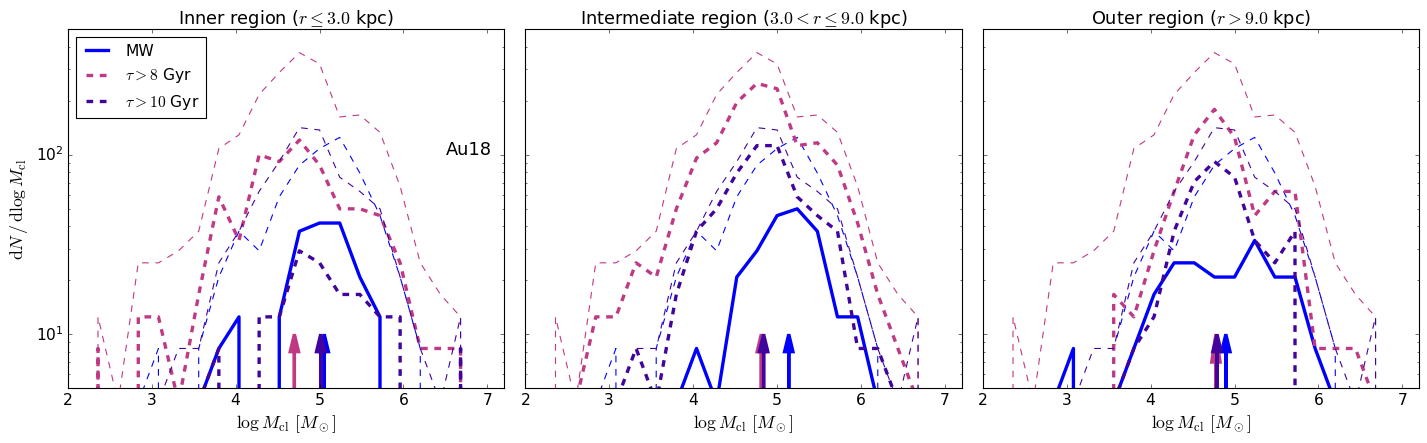

In [8]:
labels=['Au18']
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
for ii, sim in enumerate(simulation_list[1:-1]):
    all_init, all_full, all_young, all_intermediate, all_old = get_mass_functions(sim, snapshot=127, age_intermediate=8., age_old=10., apply_df=False,
                                                                                       decomposition='Spheroid', low_mass_cut=1e5, high_mass_cut=None, plot_decomposition=False)
    inner_init, inner_full, inner_young, inner_intermediate, inner_old = get_mass_functions(sim, snapshot=127, outer_radius=3., age_intermediate=8., age_old=10., apply_df=False,
                                                                                       decomposition='Spheroid', low_mass_cut=1e5, high_mass_cut=None, plot_decomposition=False)
    intermediate_init, intermediate_full, intermediate_young, intermediate_intermediate, intermediate_old = get_mass_functions(sim, snapshot=127, inner_radius=3., outer_radius=None, age_intermediate=8., age_old=10., apply_df=False,
                                                                                       decomposition='Spheroid', low_mass_cut=1e5, high_mass_cut=None, plot_decomposition=False)
    outer_init, outer_full, outer_young, outer_intermediate, outer_old = get_mass_functions(sim, snapshot=127, inner_radius=9., age_intermediate=8., age_old=10., apply_df=False,
                                                                                       decomposition='Spheroid', low_mass_cut=1e5, high_mass_cut=None, plot_decomposition=False)

    fig, ax = plt.subplots(1,3, figsize=(18,6), sharey=True)

    # ax[0].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
    # ax[0].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
    # ax[0].plot(imarray_plot, all_init, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    # # ax[0].plot(marray_plot, all_full, c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
    # ax[0].plot(marray_plot, all_intermediate, c=colors[1], linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 8$ Gyr)')
    # ax[0].plot(marray_plot, all_old, c=colors[2], linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
    # ax[0].set_title(labels[ii]+', all GCs', fontsize=16)
    # ax[0].set_xlim(2,7.2)
    # ax[0].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
    # ax[0].tick_params(labelsize=14)

    ax[0].plot(marray_plot, mw_mass_function, linewidth=1, c='b', linestyle='dashed')
    ax[0].plot(marray_plot, mw_inner_mass_function, linewidth=3, c='b', label='MW')
    popt, _ = curve_fit(log_normal, marray_plot, mw_inner_mass_function, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[0].arrow(mu, 5e0, 0, 5, color='b', linewidth=3, head_width=0.1, head_length=2, length_includes_head=True)
    # ax[0].plot(marray_plot, m31_inner_mass_function, linewidth=3, c='r', label='M31')
    # ax[0].plot(marray_plot, inner_init, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    # ax[0].plot(marray_plot, inner_full, c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
    ax[0].plot(marray_plot, all_intermediate, c=colors[1], linestyle='dashed', linewidth = 1)
    ax[0].plot(marray_plot, inner_intermediate, c=colors[1], linestyle='dashed', linewidth = 3, label=r'$\tau > 8$ Gyr')
    popt, _ = curve_fit(log_normal, marray_plot, inner_intermediate, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[0].arrow(mu, 5e0, 0, 5, color=colors[1], linewidth=3, head_width=0.1, head_length=2, length_includes_head=True)
    ax[0].plot(marray_plot, all_old, c=colors[2], linestyle='dashed', linewidth = 1)
    ax[0].plot(marray_plot, inner_old, c=colors[2], linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    popt, _ = curve_fit(log_normal, marray_plot, inner_old, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[0].arrow(mu, 5e0, 0, 5, color=colors[2], linewidth=3, head_width=0.1, head_length=2, length_includes_head=True)
    ax[0].set_title(r'Inner region ($r \leq 3.0$ kpc)', fontsize=16)
    ax[0].set_xlim(2,7.2)
    ax[0].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
    ax[0].tick_params(labelsize=14)
    
    ax[1].plot(marray_plot, mw_mass_function, linewidth=1, c='b', linestyle='dashed')
    ax[1].plot(marray_plot, mw_intermediate_mass_function, linewidth=3, c='b', label='MW')
    popt, _ = curve_fit(log_normal, marray_plot, mw_intermediate_mass_function, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[1].arrow(mu, 5e0, 0, 5, color='b', linewidth=3, head_width=0.1, head_length=2, length_includes_head=True)
    # ax[1].plot(marray_plot, m31_intermediate_mass_function, linewidth=3, c='r', label='M31')
    # ax[1].plot(marray_plot, intermediate_init, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    # ax[1].plot(marray_plot, intermediate_full, c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
    ax[1].plot(marray_plot, all_intermediate, c=colors[1], linestyle='dashed', linewidth = 1)
    ax[1].plot(marray_plot, intermediate_intermediate, c=colors[1], linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 8$ Gyr)')
    popt, _ = curve_fit(log_normal, marray_plot, intermediate_intermediate, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[1].arrow(mu, 5e0, 0, 5, color=colors[1], linewidth=3, head_width=0.1, head_length=2, length_includes_head=True)
    ax[1].plot(marray_plot, all_old, c=colors[2], linestyle='dashed', linewidth = 1)
    ax[1].plot(marray_plot, intermediate_old, c=colors[2], linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    popt, _ = curve_fit(log_normal, marray_plot, intermediate_old, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[1].arrow(mu, 5e0, 0, 5, color=colors[2], linewidth=3, head_width=0.1, head_length=2, length_includes_head=True)
    ax[1].set_title(r'Intermediate region ($3.0 < r \leq 9.0$ kpc)', fontsize=16)
    ax[1].set_xlim(2,7.2)
    ax[1].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
    ax[1].tick_params(labelsize=14)

    ax[2].plot(marray_plot, mw_mass_function, linewidth=1, c='b', linestyle='dashed')
    ax[2].plot(marray_plot, mw_outer_mass_function, linewidth=3, c='b', label='MW')
    popt, _ = curve_fit(log_normal, marray_plot, mw_outer_mass_function, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[2].arrow(mu, 5e0, 0, 5, color='b', linewidth=3, head_width=0.1, head_length=2, length_includes_head=True)
    # ax[2].plot(marray_plot, m31_outer_mass_function, linewidth=3, c='r', label='M31')
    # ax[2].plot(marray_plot, outer_init, c='k', linestyle='dashed', linewidth = 3, label='CIMF')
    # ax[2].plot(marray_plot, outer_full, c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
    ax[2].plot(marray_plot, all_intermediate, c=colors[1], linestyle='dashed', linewidth = 1)
    ax[2].plot(marray_plot, outer_intermediate, c=colors[1], linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 8$ Gyr)')
    popt, _ = curve_fit(log_normal, marray_plot, outer_intermediate, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[2].arrow(mu, 5e0, 0, 5, color=colors[1], linewidth=3, head_width=0.1, head_length=3, length_includes_head=True)
    ax[2].plot(marray_plot, all_old, c=colors[2], linestyle='dashed', linewidth =1)
    ax[2].plot(marray_plot, outer_old, c=colors[2], linestyle='dashed', linewidth = 3, label=r'$\tau > 10$ Gyr')
    popt, _ = curve_fit(log_normal, marray_plot, outer_old, p0=[1e3, 5, 0.5])
    A, mu, sigma = popt
    ax[2].arrow(mu, 5e0, 0, 5, color=colors[2], linewidth=3, head_width=0.1, head_length=2, length_includes_head=True)
    ax[2].set_title(r'Outer region ($r > 9.0$ kpc)', fontsize=16)
    ax[2].set_xlim(2,7.2)
    ax[2].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
    ax[2].tick_params(labelsize=14)

    ax[0].text(6.5, 1e2, 'Au18', fontsize=16, color='k')
    ax[0].set(ylim=(5e0,5e2), yscale= 'log')
    ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
    ax[0].legend(loc='upper left', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # fig.suptitle(sim, fontsize=15)
    # plt.savefig('plots/f1_2_shboost_gcmf_radialbins.pdf')

In [29]:
dir = './lvl5_testruns/'
simulation_list = [directory for directory in os.listdir(dir) if 'Au6_lvl5_cfea' in directory]
print(simulation_list)
# simulation_list = [simulation_list[1], simulation_list[10]]
# print(simulation_list)

['Au6_lvl5_cfea_fulltensor', 'Au6_lvl5_cfea_fiducial']


In [30]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []
# labels = []

for sim in simulation_list:
    # labels.append(sim)
    init, full, young, intermediate, old = get_mass_functions(dir+sim, snapshot=127, apply_df=False, age_intermediate=6, decomposition='Spheroid')
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

Loading simulation: ./lvl5_testruns/Au6_lvl5_cfea_fulltensor
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 12
Maximum initial mass 1.81e+07 Msun
Maximum present-day mass 5.91e+06 Msun
Problematic stars with clusters   26
That`s 0.974 per cent of stars with clusters
Loading simulation: ./lvl5_testruns/Au6_lvl5_cfea_fiducial
galrad= 0.01945979
Found 78325 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Stellar mass of the galaxy: 3.23e+10 Msun
Redshift of the simulation: 0.00
GMM Label for Spheroid: 0
Maximum initial number of clusters per star 11
Maximum initial mass 1.46e+07 Msun
Maximum present-day mass 8.27e+06 Msun
Problematic stars with clusters   39
That`s 1.578 per cent of stars with clusters


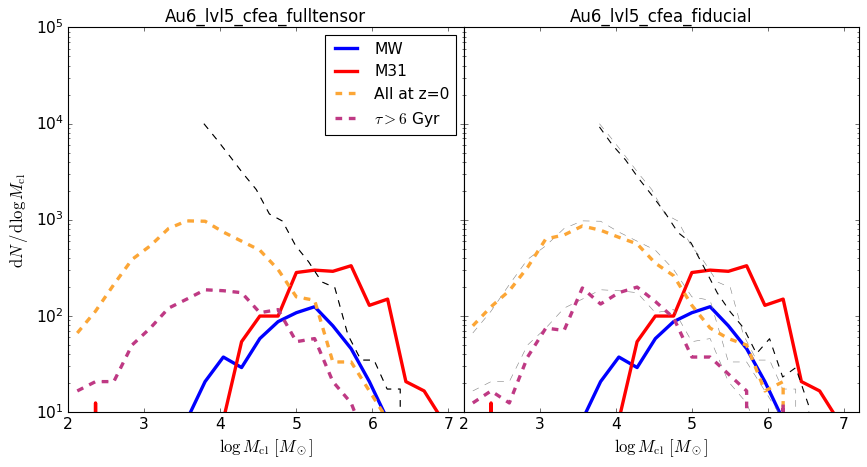

In [32]:
nsubs = 2
colors = plt.cm.plasma(1 - np.linspace(0.2,0.9,3))
labels = simulation_list

fig, ax = plt.subplots(1, nsubs, sharey=True, figsize=(nsubs*5 + 1,6))

for i in range(len(ax)):
  ax[i].plot(marray_plot, mw_mass_function, linewidth=3, c='b', label='MW')
  ax[i].plot(marray_plot, m31_mass_function, linewidth=3, c='r', label='M31')
  ax[i].set_xlim(2,7.2)
  ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(labels[i], fontsize=15)

for i,mf in enumerate(initial_population):
  # if((i+1)%2 == 0):
  ax[i].plot(imarray_plot, initial_population[0], c='grey', linewidth=0.5, linestyle='--')
  ax[i].plot(imarray_plot, mf, c='k', linewidth=1, linestyle='--')

for i,mf in enumerate(full_population):
  # if((i+1)%2 == 0):
  ax[i].plot(marray_plot, full_population[0], c='grey', linewidth=0.5, linestyle='--')
  ax[i].plot(marray_plot, mf, c=colors[0], linewidth=3, linestyle='--', label='All at z=0')

# for i,mf in enumerate(young_population):
#   # if((i+1)%2 == 0):
#   ax[i].plot(marray_plot, mf, c='k', linewidth=1, linestyle=':', label=r'$\tau < 0.5$ Gyr')

for i,mf in enumerate(intermediate_population):
  # if((i+1)%2 == 0):
  ax[i].plot(marray_plot, intermediate_population[0], c='grey', linewidth=0.5, linestyle='--')
  ax[i].plot(marray_plot, mf, c=colors[1], linewidth=3, linestyle='--', label=r'$\tau > 6$ Gyr')
  
# for i,mf in enumerate(old_population):
#   # if((i+1)%2 == 0):
#   ax[i].plot(marray_plot, old_population[0], c='grey', linewidth=0.5)
#   ax[i].plot(marray_plot, mf, c='olive', linewidth=3, label=r'$\tau > 10$ Gyr')

ax[0].set(ylim=(1e1,1e5), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax[0].legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('plots/.pdf')

# Current state of simulated GCMF

In [2]:
nbins = 25
min_gcmf = 1e2 # in solar masses
min_icmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)
marray_plot = 0.5 * (marray_gcmf[:-1] + marray_gcmf[1:])
imarray_plot = 0.5 * (marray_icmf[:-1] + marray_icmf[1:])

In [3]:
m31_masses = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/Caldwell_dataonly.txt', usecols=11, delimiter=',')
m31_rgc = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/Caldwell_dataonly.txt', usecols=12, delimiter=',')
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(m31_masses[m31_rgc <= 3.], bins=marray_gcmf)
m31_inner_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 3.) * (m31_rgc <= 9.)], bins=marray_gcmf)
m31_intermediate_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 9.)], bins=marray_gcmf)
m31_outer_mass_function = N/width

mw_catalogue = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
mw_rgc = mw_catalogue[:,2]
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width
N,_ = np.histogram(mw_masses[mw_rgc <= 3.], bins=marray_gcmf)
mw_inner_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 3.) * (mw_rgc <= 9.)], bins=marray_gcmf)
mw_intermediate_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 9.)], bins=marray_gcmf)
mw_outer_mass_function = N/width

In [4]:
emosaics = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/emosaics_gcmf.csv', delimiter=',', skip_header=2)
emp2022 = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/emp2022_gcmf.csv', delimiter=',', skip_header=2)
emp2023 = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/emp2023_gcmf.csv', delimiter=',', skip_header=2)
gbf2023 = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/gbf2023_gcmf.csv', delimiter=',', skip_header=2)
lignedin2019 = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/lignedin2019_gcmf.csv', delimiter=',', skip_header=2)
twophase = np.genfromtxt('/home/pdcg/Documents/post_process_routines/data/TwoPhase_GCs.csv', delimiter=',')

In [5]:
emosaics_masses = emosaics[:,::2]
emosaics_counts = emosaics[:,1::2]

In [6]:
dn = np.zeros((marray_plot.size,10))
for i in range(10):
    for j in range(marray_plot.size):
        min_idx = np.nanargmin(np.abs(emosaics_masses[:,i] - marray_plot[j]))
        dn[j,i] = emosaics_counts[min_idx,i]

Text(0, 0.5, '$\\mathrm{d}N \\, / \\, \\mathrm{d} \\log M_{\\mathrm{cl}}$')

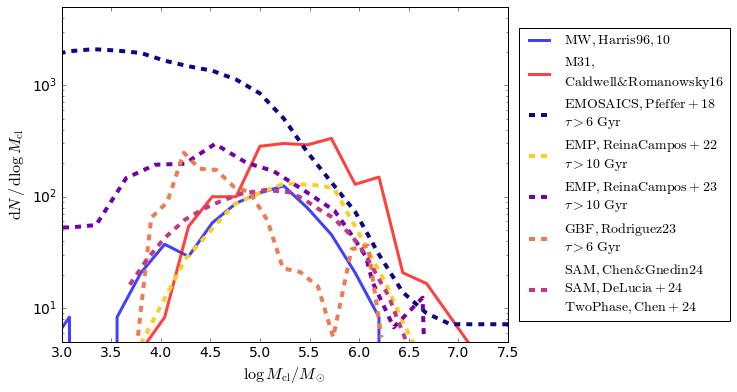

In [8]:
colors = plt.cm.plasma(np.linspace(0,0.9,5))
plt.figure(figsize=(8,6))
plt.plot(marray_plot, mw_mass_function, c='b', linewidth=3, alpha=0.75, label=r'$\rm{MW, Harris96, 10}$')
plt.plot(marray_plot, m31_mass_function, c='r', linewidth=3, alpha=0.75, label=r'$\rm{M31,}$'+'\n'+r'$\rm{Caldwell&Romanowsky16}$')
plt.plot(marray_plot, np.median(dn, axis=1), c=colors[0], linewidth=4, linestyle='--', label=r'$\rm{EMOSAICS, Pfeffer+18}$' +'\n' +r'$\tau > 6 \; \rm{Gyr}$')
plt.plot(np.log10(emp2022[:,0]), emp2022[:,1], c=colors[4], linewidth=4, linestyle='--', label=r'$\rm{EMP, ReinaCampos+22}$' +'\n' +r'$\tau > 10 \; \rm{Gyr}$')
plt.plot(emp2023[:,0], emp2023[:,1], c=colors[1], linewidth=4, linestyle='--', label=r'$\rm{EMP, ReinaCampos+23}$' +'\n' +r'$\tau > 10 \; \rm{Gyr}$')
plt.plot(np.log10(gbf2023[:,0]), 8*gbf2023[:,1], c=colors[3], linewidth=4, linestyle='--', label=r'$\rm{GBF, Rodriguez23}$' +'\n' +r'$\tau > 6 \; \rm{Gyr}$')
plt.plot(twophase[:,0]-.3, twophase[:,1], c=colors[2], linewidth=4, linestyle='--', label=r'$\rm{SAM, Chen&Gnedin24}$' +'\n' +r'$\rm{SAM, DeLucia+24}$' +'\n' +r'$\rm{TwoPhase, Chen+24}$')
plt.yscale('log')
plt.ylim(5e0, 5e3)
plt.xlim(3, 7.5)
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlabel(r'$\log M_{\mathrm{cl}}/M_\odot$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)


Peak for MW GCMF log-normal fit: 5.07
Peak for M31 GCMF log-normal fit: 5.41


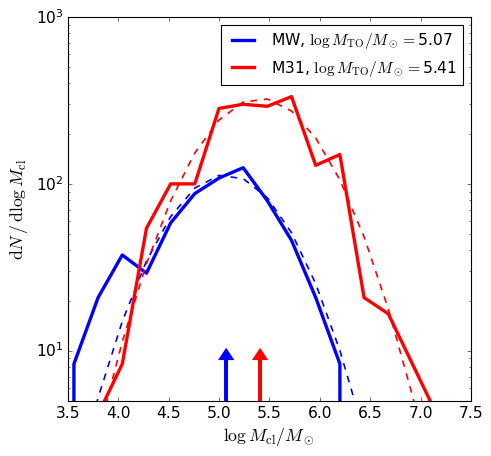

In [ ]:
# Fit the log-normal function to the data
poptmw, _ = curve_fit(log_normal, marray_plot, mw_mass_function, p0=[1e3, 5, 0.5])

# Extract the parameters
A, mu, sigma = poptmw
peakmw = mu  # The peak of the log-normal function

print(f"Peak for MW GCMF log-normal fit: {peakmw:.2f}")

# Plot the fit
plt.figure(figsize=(6.5, 6))
plt.plot(marray_plot, mw_mass_function, c='b', linewidth=3, label=r'MW, $\log M_{\rm{TO}}/M_\odot=$'+f'{peakmw:.2f}')
plt.plot(marray_plot, log_normal(marray_plot, *poptmw), c='b', linestyle='--', linewidth=1.5)
plt.arrow(peakmw, 5e0, 0, 5, color='b', linewidth=3, head_width=0.1, head_length=1, length_includes_head=True)

# Fit the log-normal function to the data
poptm31, _ = curve_fit(log_normal, marray_plot, m31_mass_function, p0=[1e3, 5, 0.5])

# Extract the parameters
A, mu, sigma = poptm31
peakm31 = mu  # The peak of the log-normal function

print(f"Peak for M31 GCMF log-normal fit: {peakm31:.2f}")

plt.plot(marray_plot, m31_mass_function, c='r', linewidth=3, label=r'M31, $\log M_{\rm{TO}}/M_\odot=$'+f'{peakm31:.2f}')
plt.plot(marray_plot, log_normal(marray_plot, *poptm31), c='r', linestyle='--', linewidth=1.5)
plt.arrow(peakm31, 5e0, 0, 5, color='r', linewidth=3, head_width=0.1, head_length=1, length_includes_head=True)

plt.yscale('log')
plt.xlabel(r'$\log M_{\mathrm{cl}}/M_\odot$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(3.5, 7.5)
plt.ylim(5e0, 1e3)
plt.show()